In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [2]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_csv("hf://datasets/nataliecastro/csci-5832-project-dataset/Cleaned Sentiment140 Dataset with Tokenized Sequences.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# Custom Dataset Class
class TwitterDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


In [4]:
# Custom Transformer Model
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_heads=4, num_layers=2, max_len=40, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding[:, :x.size(1), :]
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

In [5]:
df = df.dropna(subset=["sentiment label", "listed text"])
df = df[df["sentiment label"].isin(["Positive", "Neutral", "Negative"])]

# Convert stringified list to actual list
df["listed text"] = df["listed text"].apply(eval)

In [6]:
df.head()

,Unnamed: 0,sentiment,tweet_id,date,flag,user,text,sentiment label,masked text,listed text,truncated sequences,tokenized sequences
0,0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[USER] [URL] - Aww, that's a bummer. You shou...",Negative,"[USER] [URL] - Aww, that's a bummer. You shou...","[[USER], [URL], -, Aww, that, s, a, bummer, Yo...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, t, update, his, Fac...","[20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19...","[20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19..."
2,2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,[USER] I dived many times for the ball. Manage...,Negative,[USER] I dived many times for the ball. Manage...,"[[USER], I, dived, many, time, for, the, ball,...","[1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47...","[1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47..."
3,3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, ...","[52, 53, 54, 55, 56, 30, 57, 19, 58, 59, '[PAD...","[52, 53, 54, 55, 56, 30, 57, 19, 58, 59, '[PAD..."
4,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[USER] no, it's not behaving at all. i'm mad. ...",Negative,"[USER] no, it's not behaving at all. i'm mad. ...","[[USER], no, it, s, not, behaving, at, all, i,...","[1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,...","[1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,..."


In [7]:
# Label encoding
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment label"])  # Positive = 1, Negative = 0

# Token Indexing
token2index = {tok: idx+1 for idx, tok in enumerate({t for d in df["listed text"] for t in d})}
token2index["[PAD]"] = 0
index2token = {v: k for k, v in token2index.items()}

In [8]:
def doc_to_idx(doc):
    return [token2index.get(tok, 0) for tok in doc]

def pad_seq(seq, max_len=40):
    return seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]


In [9]:
df["sequence"] = df["listed text"].apply(doc_to_idx).apply(lambda x: pad_seq(x, max_len=40))

# Train/test split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df["sequence"].tolist(), df["label"].tolist(), test_size=0.2)

In [11]:
# Create Datasets
train_dataset = TwitterDataset(X_train, y_train)
val_dataset = TwitterDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [12]:
# === Model Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer(vocab_size=len(token2index), num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
def evaluate_model(model, test_loader, threshold=0.5, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).view(-1)
            preds = (preds >= threshold).long()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\nEvaluation:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return all_preds, all_labels, accuracy, precision, recall, f1

In [17]:
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=5,
    print_metrics=True
):
    model.to(device)
    metrics_log = {
        "train_loss": [],
        "val_accuracy": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch_x, batch_y in train_bar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)

        # === Validation Phase ===
        model.eval()
        all_preds = []
        all_labels = []

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        with torch.no_grad():
            for batch_x, batch_y in val_bar:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(batch_y.cpu().tolist())

        # Metrics
        val_acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # Log metrics
        metrics_log["train_loss"].append(avg_loss)
        metrics_log["val_accuracy"].append(val_acc)
        metrics_log["val_precision"].append(precision)
        metrics_log["val_recall"].append(recall)
        metrics_log["val_f1"].append(f1)

        if print_metrics:
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")
            print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}\n")

    return model, metrics_log


## With Attention

In [18]:
import torch
import torch.nn as nn

class CustomCausalTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_heads=4, num_layers=2, max_len=40, num_classes=3, causal=False):
        super().__init__()
        self.causal = causal
        self.max_len = max_len

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(embed_dim, num_classes)

    def generate_causal_mask(self, seq_len, device):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf')).to(device)
        return mask

    def forward(self, x):
        # x: (batch_size, seq_len)
        batch_size, seq_len = x.shape

        x = self.embedding(x) + self.pos_embedding[:, :seq_len, :]

        # Generate attention mask (optional)
        if self.causal:
            attn_mask = self.generate_causal_mask(seq_len, x.device)  # shape [seq_len, seq_len]
        else:
            attn_mask = None

        x = self.encoder(x.transpose(0, 1), mask=attn_mask)  # shape [seq_len, batch_size, embed_dim]
        x = x.transpose(0, 1)  # back to [batch_size, seq_len, embed_dim]

        pooled = x.mean(dim=1)  # mean pooling over sequence
        return self.classifier(pooled)


In [19]:
# For sentiment classification with causal masking ON
model = CustomCausalTransformer(
    vocab_size=len(token2index),
    embed_dim=128,
    n_heads=4,
    num_layers=2,
    max_len=40,
    num_classes=3,     # 3 for positive/neutral/negative
    causal=True        # Set to False for bidirectional attention (like BERT)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

model, log = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=2
)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Epoch 1/2
Train Loss: 0.4941 | Val Acc: 0.7907
Precision: 0.7908 | Recall: 0.7907 | F1 Score: 0.7907




Epoch 2/2
Train Loss: 0.4315 | Val Acc: 0.8043
Precision: 0.8051 | Recall: 0.8041 | F1 Score: 0.8041



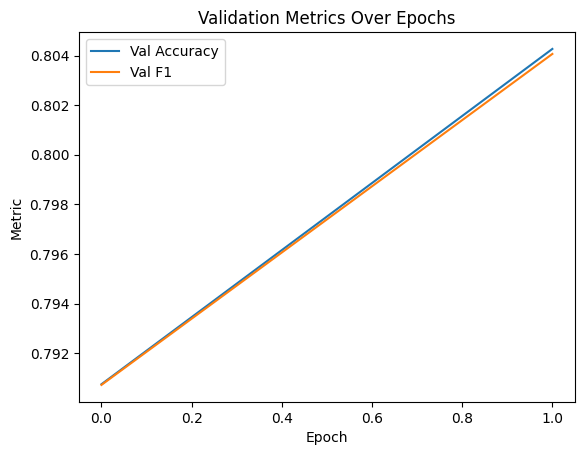

In [20]:
import matplotlib.pyplot as plt

plt.plot(log["val_accuracy"], label="Val Accuracy")
plt.plot(log["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Validation Metrics Over Epochs")
plt.show()
